<a href="https://colab.research.google.com/github/raina-11/variational_autoencoders/blob/master/VAE_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

In [2]:
# Parameters
learning_rate = 0.001
num_epoch = 2
batch_size = 64

# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 2

In [3]:
#trainset
traindataset=datasets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
trainloader=torch.utils.data.DataLoader(dataset=traindataset,
                                        batch_size=batch_size,
                                        shuffle=True)
#testset
testdataset=datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)
testloader=torch.utils.data.DataLoader(testdataset,
                                       batch_size=batch_size,
                                        shuffle=False)


In [4]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1=nn.Conv2d(1,64,4,stride=2,padding=1)
    self.conv2=nn.Conv2d(64,128,4,2,padding=1)
    self.fc_mu=nn.Linear(128*7*7,out_features=latent_dim)
    self.fc_logvar=nn.Linear(128*7*7,out_features=latent_dim)

  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=x.view(x.size(0), -1)
    x_mu = self.fc_mu(x)
    x_logvar = self.fc_logvar(x)
    return x_mu, x_logvar

In [5]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc1=nn.Linear(in_features=latent_dim,out_features=128*7*7)
    self.conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.conv1=nn.ConvTranspose2d(in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=1)

  def forward(self,x):
    x=self.fc1(x)
    x = x.view(x.size(0), 128, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
    x = F.relu(self.conv2(x))
    x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE(binary cross entropy) as reconstruction loss
    return x

In [6]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder=Encoder()
    self.decoder=Decoder()
  
  def forward(self,x):
    latent_mu,latent_logvar=self.encoder(x)
    latent=self.latent_sample(latent_mu,latent_logvar)
    x_recon = self.decoder(latent)
    return x_recon,latent_mu,latent_logvar

  def latent_sample(self, mu, logvar):
    if self.training:
      #Reparameterization Trick
      std=logvar.mul(0.5).exp_()
      eps=torch.empty_like(std).normal_()
      return eps.mul(std).add_(mu)
    else:
      return mu

In [7]:
variational_beta=1
def vae_loss(recon_x,x,mu,logvar):
   # recon_x is the probability of a multivariate Bernoulli distribution p.
   recon_loss=F.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),reduction='sum')
   kldivergence=-0.5*torch.sum(1 +logvar -mu.pow(2)- logvar.exp())
   return recon_loss + variational_beta * kldivergence

In [8]:
vae = VAE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)

In [9]:
optimizer = optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)


In [10]:
#counting the number of parameters
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


In [11]:
#TRAINING VAE
vae.train()
train_loss_avg=[]
for epoch in range(num_epoch):
  train_loss_avg.append(0)
  num_batches=0

  for image_batch,_ in trainloader:

    image_batch=image_batch.to(device)
    #vae reconstruction
    image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

    #reconstruction error
    loss=vae_loss(image_batch_recon,image_batch,latent_mu,latent_logvar)
   # backpropagation
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
        
    train_loss_avg[-1] += loss.item()
    num_batches += 1

  train_loss_avg[-1] /= num_batches

  print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epoch, train_loss_avg[-1]))




Epoch [1 / 2] average reconstruction error: 11437.179117
Epoch [2 / 2] average reconstruction error: 10379.825775


In [13]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in testloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 10148.679890


Original images


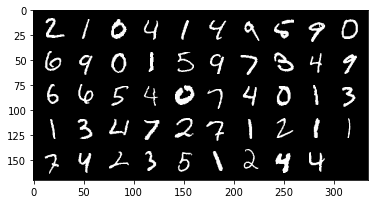

VAE reconstruction:


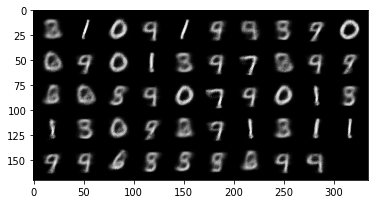

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(testloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)